# Visualization

In [1]:
%load_ext autoreload
%autoreload 2

import pickle
import autograd.numpy as np
import matplotlib.pyplot as plt

from counterfactualgp.gp import GP
from counterfactualgp.mean import linear_mean
from counterfactualgp.treatment import DummyTreatment, Treatment
from counterfactualgp.mpp import BinaryActionModel
from counterfactualgp.cov import iid_cov, se_cov

In [2]:
with open('dataset/data_set_bspline_3classes.pkl', 'rb') as fin:
    data = pickle.load(fin)

In [3]:
low, high = 0.0, 24.0

In [4]:
def predict(gp, y, x, x_star):
    t, rx = x
    t_star, rx_star = x_star
    yhat, cov_hat = gp.predict((t_star, rx_star), y, (t, rx))
        
    return yhat, cov_hat

In [5]:
def draw_samples(gp, samples, t_star, rx_star, nrow=3, ncol=3, title='',
                 truncated_time=None, copy_truncated_rx=False):
    
    def _concat_x(t1, rx1, t2, rx2):
        t = np.concatenate([t1, t2])
        rx = np.concatenate([rx1, rx2])
        idx = np.argsort(t)
        return t[idx], rx[idx]
    
    # reset `rx_star` if not truncated
    if truncated_time is not None:
        rx_star[t_star <= truncated_time] = 0
    else:
        rx_star = np.zeros(rx_star.shape[0])
    
    fig, axes = plt.subplots(nrow, ncol, sharex=True, figsize=(12,6), sharey=True)
    for i in range(nrow):
        for j in range(ncol):
            idx = i*nrow+j            
            y, x = samples[idx]
            t, rx = x
            
            if truncated_time is not None:
                _y = y[t <= truncated_time]
                _t = t[t <= truncated_time]
                _rx = rx[t <= truncated_time]
                if copy_truncated_rx:
                    _t_star, _rx_star = _concat_x(t, rx, t_star, rx_star)
                else:
                    _t_star, _rx_star = _concat_x(_t, _rx, t_star, rx_star)
            else:
                _y, _t, _rx = y, t, rx
                _t_star, _rx_star = _concat_x(_t, _rx, t_star, rx_star)
            
            yhat, cov_hat = predict(gp, _y, (_t, _rx), (_t_star, _rx_star))
            y_std = np.diag(cov_hat)
            
            axes[i, j].plot(_t_star, yhat, color='b')
            axes[i, j].scatter(t, y, marker='o', color='r')
            for _tt, _rx in zip(t, rx):
                if _rx == 1:
                    axes[i, j].axvline(x=_tt, color = 'y')
            axes[i, j].fill_between(_t_star, yhat - y_std, yhat + y_std,
                                 alpha=0.2, color='k')
            if truncated_time is not None:
                axes[i, j].axvline(x=truncated_time, color='r', ls='--')
    fig.suptitle(title)
    plt.show()

## Baseline GP without treatment

In [6]:
m = linear_mean(1)
tr = []
tr.append( (1.0, DummyTreatment()) )
bgp = GP(m, se_cov(a=1.0, l=1.0), tr, ac_fn=None)
bgp.fit(data['training2'], init = False)
print(bgp.params)

obj= 6083.04235686093
obj= 5141.529385264423
obj= 5086.223249617866
obj= 4655.807887319782
obj= 4505.852231684764
obj= 4501.834878895523
obj= 4501.786818876769
obj= 4501.786758444665
obj= 4501.786745434913
obj= 4501.786745433863
{'linear_mean_coef': array([-0.03449169,  0.97797757]), 'ln_cov_l_F': array([0.]), 'ln_cov_a_F': array([0.]), 'ln_cov_y': array([-2.28161926])}


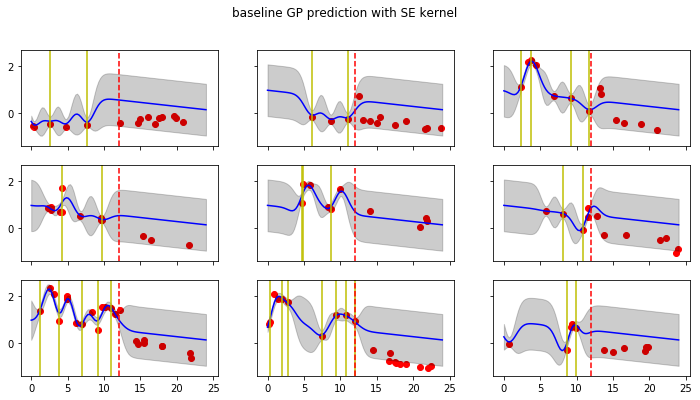

In [7]:
t_star = np.linspace(low, high, num = 100)
rx_star = np.zeros(len(t_star))

draw_samples(bgp, data['testing1'][0:9], t_star, rx_star, 
             3, 3, 'baseline GP prediction with SE kernel', data['truncated_time'])

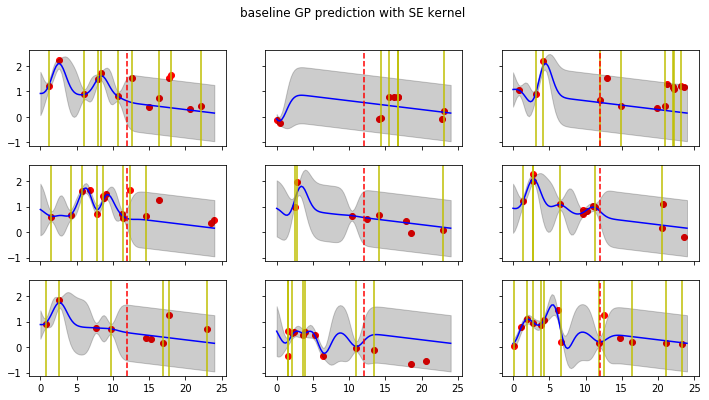

In [8]:
t_star = np.linspace(low, high, num = 100)
rx_star = np.zeros(len(t_star))

draw_samples(bgp, data['training2'][0:9], t_star, rx_star, 
             3, 3, 'baseline GP prediction with SE kernel', 
             data['truncated_time'], copy_truncated_rx=True)

## Baseline GP with treatment

In [9]:
m = linear_mean(1)
tr = []
tr.append( (1.0, Treatment(2.0)) )
bgp_rx = GP(m, se_cov(a=1.0, l=1.0), tr, ac_fn=None)
bgp_rx.fit(data['training2'], init = False)
print(bgp_rx.params)

obj= 6078.540759999163
obj= 5101.595047511066
obj= 4032.322203864577
obj= 4023.7202464326756
obj= 3942.164818349509
obj= 3805.011892490622
obj= 3726.9860434833718
obj= 3718.592518993516
obj= 3717.795824520061
obj= 3717.7718931514414
obj= 3717.7691487427346
obj= 3717.769145067813
obj= 3717.769145014389
obj= 3717.7691450143875
{'linear_mean_coef': array([-0.036878  ,  0.72001371]), 'ln_cov_l_F': array([0.]), 'effects_window_F': array([2.]), 'treatment': array([0.53383155]), 'ln_cov_y': array([-2.93898684]), 'ln_cov_a_F': array([0.])}


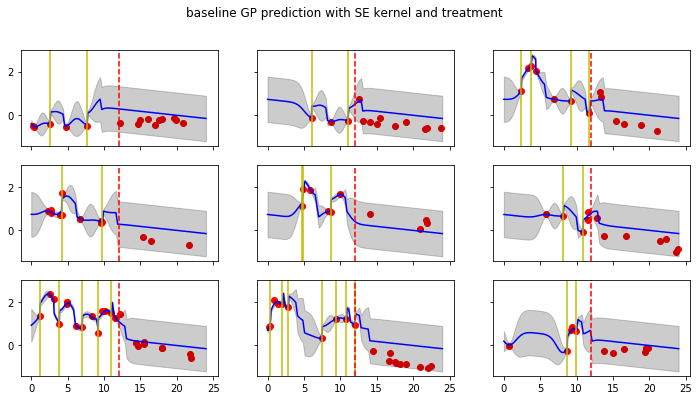

In [10]:
t_star = np.linspace(low, high, num = 100)
rx_star = np.zeros(len(t_star))

draw_samples(bgp_rx, data['testing1'][0:9], t_star, rx_star, 
             3, 3, 'baseline GP prediction with SE kernel and treatment', 
             data['truncated_time'])

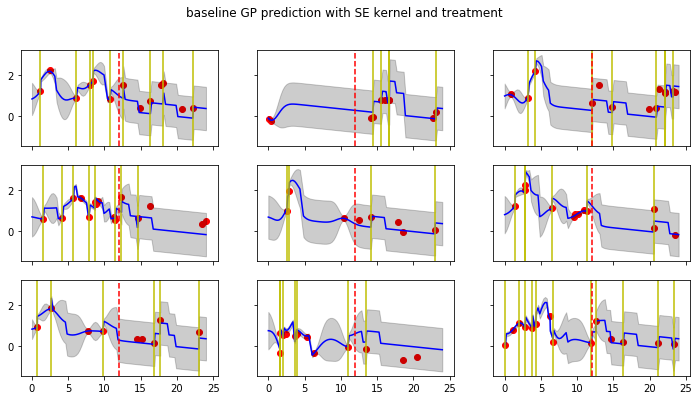

In [11]:
t_star = np.linspace(low, high, num = 100)
rx_star = np.zeros(len(t_star))

draw_samples(bgp_rx, data['training2'][0:9], t_star, rx_star, 
             3, 3, 'baseline GP prediction with SE kernel and treatment', 
             data['truncated_time'], copy_truncated_rx=True)

## Counterfactual GP

In [12]:
m = linear_mean(1)
tr = []
tr.append( (0.0, DummyTreatment()) )
tr.append( (1.0, Treatment(2.0)) )
ac = BinaryActionModel()
cgp = GP(m, se_cov(a=1.0, l=1.0), tr, ac_fn=ac)
cgp.fit(data['training2'], init = False)
print(cgp.params)

obj= [9202.78002347]
obj= [8158.4281315]
obj= [8004.66897643]
obj= [7982.39888729]
obj= [7972.96035491]
obj= [7605.34865651]
obj= [7044.400206]
obj= [6882.2939527]
obj= [6877.95062871]
obj= [6876.46438471]
obj= [6875.79385161]
obj= [6875.77976576]
obj= [6875.77933704]
obj= [6875.77933297]
obj= [6875.77933285]
obj= [6875.77933285]
obj= [6875.77933285]
{'linear_mean_coef': array([-0.03743751,  0.74622103]), 'ln_cov_l_F': array([0.]), 'effects_window_F': array([2.]), 'treatment': array([0.60942898]), 'action': array([0.35343336]), 'ln_cov_y': array([-3.06026795]), 'ln_cov_a_F': array([0.])}


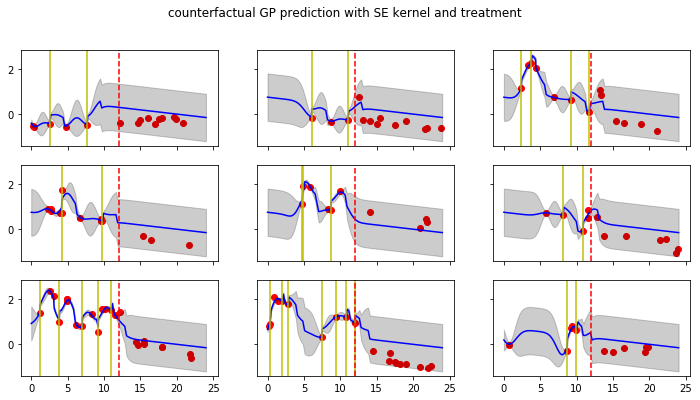

In [13]:
t_star = np.linspace(low, high, num = 100)
rx_star = np.zeros(len(t_star))

draw_samples(cgp, data['testing1'][0:9], t_star, rx_star, 
             3, 3, 'counterfactual GP prediction with SE kernel and treatment', 
             data['truncated_time'])

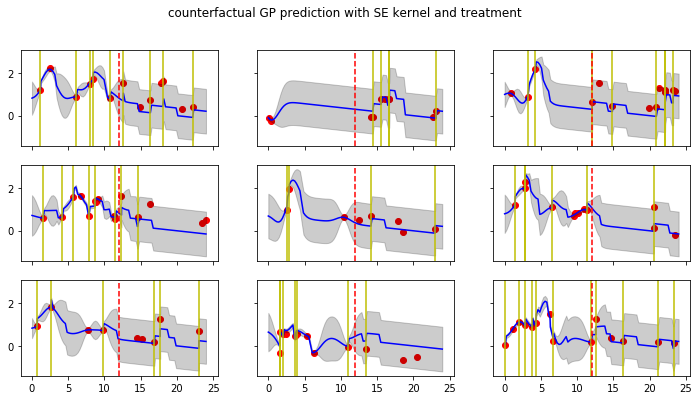

In [14]:
t_star = np.linspace(low, high, num = 100)
rx_star = np.zeros(len(t_star))

draw_samples(cgp, data['training2'][0:9], t_star, rx_star, 
             3, 3, 'counterfactual GP prediction with SE kernel and treatment', 
             data['truncated_time'], copy_truncated_rx=True)

# MSE

In [15]:
def MSE(gp, samples, truncated_time):
    '''
    Calculate the MSE metric over points after `truncated_time`.
    '''
    s = 0.0
    for y, x in samples:
        t, rx = x
        idx = t <= truncated_time
        _y = y[idx]
        _t = t[idx]
        _rx = rx[idx]

        yhat, cov_hat = predict(gp, _y, (_t, _rx), (t, rx))
        s += np.sum((yhat[~idx] - y[~idx]) **2) / y[~idx].shape[0]
    
    return s / len(samples)

In [16]:
print('bgp', MSE(bgp, data['testing1'], data['truncated_time']))
print('bgp_rx', MSE(bgp_rx, data['testing1'], data['truncated_time']))
print('cgp_rx', MSE(cgp, data['testing1'], data['truncated_time']))

bgp 0.3525033815325132
bgp_rx 0.17477768052367457
cgp_rx 0.18312602023472832


In [17]:
print('bgp', MSE(bgp, data['training2'], data['truncated_time']))
print('bgp_rx', MSE(bgp_rx, data['training2'], data['truncated_time']))
print('cgp_rx', MSE(cgp, data['training2'], data['truncated_time']))

bgp 0.3951432439850048
bgp_rx 0.20344206503806792
cgp_rx 0.23711715245384202
